<a href="https://colab.research.google.com/github/kimjeongsoo20190147/fisa04/blob/main/0307_DL02_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**목차**

- 프로젝트 1 - 자동차 연비 예측하기
  - 특성 열 사용하기
  - DNN 회귀 모델 훈련하기

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from IPython.display import Image

## 프로젝트 1 - 자동차 연비 예측하기 (교재 557p ~)


-  1970년대 후반과 1980년대 초반에 출시된 자동차의 연비를 예측하는 모델을 구축하는 방법을 보여줍니다. 이를 위해 해당 기간의 많은 자동차에 대한 설명을 모델에 제공해야 합니다. 이 설명에는 실린더, 배기량, 마력 및 무게와 같은 속성이 포함됩니다.
-  훈련 모델의 복잡도를 단순화하기 위해 연식을 그룹으로 묶습니다. 더 최신 차일수록 높은 점수를 부여합니다.(서수형 이산 변수)
- "Origin" 열은 숫자가 아닌 범주형입니다. 따라서 이 열의 값은 원-핫 인코딩합니다.


###  특성 열 사용하기

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch13/figures/13_07.png', width=700)

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# MPG - 연비   y
#   'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'   X
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [8]:
#df.info() # horsepower에 빈 값 6개 있음 -> 어떻게 처리해야할지 고민해야함
# 보통 중앙값, 평균, 최빈값을 넣어줌
# null이 있는 행이 겹치지 않고, 5% 내외라면 drop 하는 것도 한가지 방법임

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [4]:
df.describe()
# 성능이 좋지 않으면 scaling 해봐야겠구나

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [9]:
import sklearn
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
338,27.2,4,135.0,84.0,2490.0,15.7,81,1
260,18.6,6,225.0,110.0,3620.0,18.7,78,1
141,29.0,4,98.0,83.0,2219.0,16.5,74,2
312,37.2,4,86.0,65.0,2019.0,16.4,80,3
353,33.0,4,105.0,74.0,2190.0,14.2,81,2
...,...,...,...,...,...,...,...,...
205,28.0,4,97.0,75.0,2155.0,16.4,76,3
257,19.4,6,232.0,90.0,3210.0,17.2,78,1
73,13.0,8,307.0,130.0,4098.0,14.0,72,1
237,30.5,4,98.0,63.0,2051.0,17.0,77,1


# Nomalization(정규화)

- 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

- 이것이 중요한 한 가지 이유는 특성에 모델 가중치가 곱해지기 때문입니다. 따라서 출력의 스케일과 그래디언트의 스케일은 입력 스케일의 영향을 받습니다.

- 모델은 특성 정규화 없이 수렴할 *수도* 있지만 정규화는 훈련을 훨씬 더 안정적으로 만듭니다.

* 데이터의 특징 스케일링(feature scaling)을 위한 방법으로 표준화(Standardization)와 정규화(Normalization)를 주로 사용합니다.
![](https://miro.medium.com/max/1400/1*0Ox-p57oxfmaVSaJyJWyPg.png)

### 1) StandardScaler: 표준화 클래스
- 평균이 0, 분산이 1인 값으로 변환
- 각 특성값이 평균에서 표준편차의 몇 배 만큼 떨어져있는지 나타냄
- 실제 특성값의 크기와 상관 없이 동일한 조건으로 비교

+ 표준화 방법(표준점수, z-score)

\begin{equation}
x_i^{'} = \frac{x_i-mean(x)}{stdev(x)}
\end{equation}

- 기계학습 시에 전처리 단계에서 표준화를 해주는 것은 종종 성능 향상에 도움이 된다.


### 2) MinMaxScaler: 정규화 클래스

+ 정규화 방법

\begin{equation}
x_i^{'} = \frac{x_i-min(x)}{max(x)-min(x)}
\end{equation}

+ scikit-learn에서는 개별 벡터 크기를 맞추는 형태로 정규화
- 음수 값이 없으면 0 ~ 1의 값으로, 음수 값이 있으면 -1 ~ 1의 값으로 변환해준다
- 데이터 분포가 가우시안 분포가 아닐 경우에 적용

### 3) Normalizer

![](https://blog.kakaocdn.net/dn/dxgdK9/btqQPy7SuEv/1OCm80lLUbY6PkdKC2lQYk/img.png)

- 다른 스케일러는 각 특성/열의 통계치를 이용하여 진행되는데, Normalizer의 경우 각 샘플/행마다 적용되는 방식
- 한 행의 모든 특성들 사이의 유클리드 거리(L2 norm)가 1이 되도록 스케일링
- 일반적인 데이터 전처리의 상황에서 사용되는 것이 아니라, 모델, 특히 딥러닝 내 훈련 벡터에 적용. 피쳐들이 다른 단위(키, 나이, 소득 등)라면 사용하지 않음.

<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgLn0rZAyW-qQQGOvxsaBrjPwj3hrMqyJdHdwJASR9taiH6XDLOB4zxDiuuwccTZY3AkxKKSLWXm9DFjEagDtsZwN-iL1tqFOtuWFateoxkfKPExeah_0jzV-gKKFbu3Fns20q4lel2vy7nOyEAwu0vxLcZEsCPTFGqG6yFWMJEmQ5SZIUiFnEvgmBF/s1600/image1.png" width=400>

- 출처: https://blog.tensorflow.org/2022/11/whats-new-in-tensorflow-211.html

In [10]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [11]:
df.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')

In [12]:
from sklearn.preprocessing import StandardScaler

# 숫자가 의미가 있는 특성들만 따로 추려서 scaling
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']
scaler = StandardScaler()

# X의 평균, 분산 기준으로 fit
df_train_norm = df_train.copy()
df_train_norm[numeric_column_names] = scaler.fit_transform(df_train_norm[numeric_column_names])

# X_test도 transform
df_test_norm = df_test.copy()
df_test_norm[numeric_column_names] = scaler.transform(df_test_norm[numeric_column_names])

df_train_norm.describe(), df_test_norm.describe()

(              MPG     Cylinders  Displacement    Horsepower        Weight  \
 count  313.000000  3.130000e+02  3.130000e+02  3.130000e+02  3.130000e+02   
 mean    23.404153 -6.242788e-17  1.390439e-16  3.405157e-17 -1.163429e-16   
 std      7.666909  1.001601e+00  1.001601e+00  1.001601e+00  1.001601e+00   
 min      9.000000 -1.414279e+00 -1.185358e+00 -1.503753e+00 -1.591272e+00   
 25%     17.500000 -8.256227e-01 -8.341775e-01 -7.377410e-01 -8.760130e-01   
 50%     23.000000 -8.256227e-01 -4.829973e-01 -2.886996e-01 -2.433747e-01   
 75%     29.000000  1.529001e+00  6.876031e-01  4.508980e-01  7.232873e-01   
 max     46.600000  1.529001e+00  2.589829e+00  3.356460e+00  2.571630e+00   
 
        Acceleration  Model Year      Origin  
 count  3.130000e+02  313.000000  313.000000  
 mean  -3.291652e-16   75.929712    1.591054  
 std    1.001601e+00    3.675305    0.807923  
 min   -2.647689e+00   70.000000    1.000000  
 25%   -6.264045e-01   73.000000    1.000000  
 50%   -7.5145

In [ ]:
# 훈련 모델의 복잡도를 단순화하기 위해 연식을 그룹으로 묶어서 최신 차일수록 높은 점수를 부여
# 최소년도 / 최대년도 - 어느 정도 연식으로 그룹을 묶어야 균형 있게 차 대수가 할당되는지

In [13]:
df['Model Year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

In [21]:
import torch

df[['Model Year']].value_counts().sort_index()

boundaries = torch.tensor([73, 76, 79])
df_train_norm['Model Year Bucketed'] = torch.bucketize(torch.tensor(df_train_norm['Model Year'].values), boundaries, right =True)
df_test_norm['Model Year Bucketed'] = torch.bucketize(torch.tensor(df_test_norm['Model Year'].values), boundaries, right =True)

In [22]:
df_train_norm.head(1)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Model Year Bucketed
338,27.2,-0.825623,-0.531772,-0.500013,-0.556153,-0.001644,81,1,3


In [29]:
from sklearn.preprocessing import StandardScaler
from torch.nn.functional import one_hot
import torch

df['Origin'].value_counts()

# origin_1, origin_2, origin_3
#    1         0          0
#    0         0          1
# 이런 식으로 바꿔줘야함. origin의 숫자값이 의미가 있는건 아니기 때문

train_origin_encoded = one_hot(torch.tensor(df_train_norm['Origin'].values) % len(set(df_train_norm['Origin'])))
test_origin_encoded =  one_hot(torch.tensor(df_test_norm['Origin'].values) % len(set(df_train_norm['Origin'])))

In [31]:
torch.tensor(df_train_norm['Model Year Bucketed'].values)

tensor([3, 2, 1, 3, 3, 1, 3, 3, 3, 1, 2, 0, 3, 2, 0, 1, 3, 0, 2, 2, 3, 1, 2, 1,
        2, 1, 2, 3, 2, 0, 1, 3, 3, 3, 0, 0, 3, 1, 1, 3, 3, 3, 0, 2, 3, 1, 0, 3,
        2, 1, 3, 3, 3, 1, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2,
        0, 0, 1, 3, 3, 3, 1, 0, 2, 2, 2, 2, 3, 3, 2, 1, 3, 1, 0, 1, 2, 1, 3, 1,
        0, 2, 1, 2, 0, 3, 2, 2, 1, 3, 1, 0, 3, 1, 0, 3, 1, 3, 3, 3, 0, 0, 0, 2,
        0, 2, 0, 3, 3, 0, 2, 0, 3, 0, 1, 1, 0, 2, 0, 2, 3, 2, 3, 3, 3, 0, 2, 1,
        2, 0, 1, 1, 2, 3, 0, 0, 1, 1, 0, 0, 2, 2, 1, 0, 3, 2, 2, 2, 1, 3, 1, 2,
        3, 1, 3, 3, 2, 2, 3, 2, 3, 2, 0, 3, 3, 3, 2, 1, 1, 1, 3, 1, 3, 0, 1, 2,
        2, 2, 3, 1, 2, 1, 3, 0, 1, 2, 1, 1, 2, 1, 3, 0, 2, 1, 2, 2, 0, 3, 0, 3,
        0, 3, 0, 2, 0, 2, 3, 1, 3, 0, 0, 2, 2, 2, 2, 1, 3, 3, 2, 0, 2, 3, 1, 2,
        1, 3, 2, 3, 1, 1, 0, 3, 1, 3, 1, 2, 2, 3, 1, 1, 3, 2, 0, 2, 0, 0, 3, 1,
        3, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 1, 1, 3, 2, 2, 2, 3, 0, 3, 0, 3, 3, 0,
        1, 1, 3, 2, 2, 0, 0, 1, 2, 3, 2,

In [50]:
x_train = torch.cat([torch.tensor(df_train_norm[numeric_column_names].values), train_origin_encoded],1)
x_train = torch.cat([x_train, torch.tensor(df_train_norm[['Model Year Bucketed']].values)], 1).float()

In [51]:
x_test = torch.cat([torch.tensor(df_test_norm[numeric_column_names].values), test_origin_encoded],1)
x_test = torch.cat([x_test, torch.tensor(df_test_norm[['Model Year Bucketed']].values)], 1).float()
y_train = torch.tensor(df_train_norm[['MPG']].values).float()
y_test = torch.tensor(df_test_norm[['MPG']].values).float()

In [38]:
df_train_norm[['MPG']].values

array([[27.2],
       [18.6],
       [29. ],
       [37.2],
       [33. ],
       [13. ],
       [22.4],
       [44.6],
       [27.4],
       [31. ],
       [24. ],
       [28. ],
       [17.6],
       [15. ],
       [11. ],
       [12. ],
       [26.8],
       [13. ],
       [21.6],
       [20.8],
       [16.9],
       [20. ],
       [26.5],
       [18. ],
       [26. ],
       [24. ],
       [29.5],
       [20.2],
       [32.8],
       [14. ],
       [16. ],
       [31.8],
       [30.7],
       [34.1],
       [20. ],
       [15. ],
       [28.4],
       [20. ],
       [13. ],
       [35. ],
       [31. ],
       [44. ],
       [27. ],
       [17. ],
       [34.1],
       [14. ],
       [23. ],
       [28.1],
       [14.5],
       [24. ],
       [29.9],
       [36. ],
       [23.9],
       [15. ],
       [16. ],
       [20. ],
       [16. ],
       [24. ],
       [23.9],
       [11. ],
       [14. ],
       [19. ],
       [30. ],
       [21. ],
       [15. ],
       [23. ],
       [18

In [52]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [65]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))


In [66]:
model = nn.Sequential(*all_layers)

# 모델이 일하는 방식
# 손실을 측정하는 방법 - 평균제곱오차 MSELoss()
loss_fn = nn.MSELoss()

# 각 w, b를 어떤 최적화 방법으로 변경할지
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [67]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):
    loss_hist_train = 0

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        # print(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist_train += loss.item()

    if epoch % log_epochs==0:
        print(f'에포크 {epoch}  손실 {loss_hist_train/len(train_dl):.4f}')

# 데이터 300개 정도 밖에 없어서 잘 러닝되지 않음 - Adam 방식은 부적절?...

에포크 0  손실 269.4497
에포크 20  손실 8.3949
에포크 40  손실 7.8950
에포크 60  손실 7.6993
에포크 80  손실 6.9548
에포크 100  손실 6.7713
에포크 120  손실 6.2780
에포크 140  손실 6.4322
에포크 160  손실 6.9214
에포크 180  손실 6.1727


In [68]:
model.eval()

with torch.no_grad():
    pred = model(x_test) # 추론 결과 예측
    loss = loss_fn(pred, y_test)
    print(f'테스트 MSE: {loss.item():.4f}')
    # print(f'테스트 MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

테스트 MSE: 8.3262


In [ ]:
# 모델을 만들 때 W, B 0 근처의 점에서

### 한 셀에 정리

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

from sklearn.preprocessing import StandardScaler

numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

# StandardScaler 객체 생성
scaler = StandardScaler()

# 훈련 데이터에 맞춰 스케일러 적합 및 변환
df_train_norm = df_train.copy()
df_train_norm[numeric_column_names] = scaler.fit_transform(df_train[numeric_column_names])

# 테스트 데이터 변환 (훈련 데이터의 스케일에 맞춰 변환)
df_test_norm = df_test.copy()
df_test_norm[numeric_column_names] = scaler.transform(df_test[numeric_column_names])

# 결과 확인
df_train_norm.tail()

# 훈련 모델의 복잡도를 단순화하기 위해 연식을 그룹으로 묶음. 더 최신 차일수록 높은 점수 부여(서수형 이산 변수)
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

from torch.nn.functional import one_hot

## 명목형으로 된변수들을 원핫인코딩
total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()


y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

## 로더에 싣고
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

## 모델을 만들어서
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

model

## 일하는 방식 정의
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


## 실제 학습
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs==0:
        print(f'에포크 {epoch}  손실 {loss_hist_train/len(train_dl):.4f}')


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
에포크 0  손실 536.0926
에포크 20  손실 8.4366
에포크 40  손실 7.8680
에포크 60  손실 7.1842
에포크 80  손실 6.7032
에포크 100  손실 6.7553
에포크 120  손실 6.3134
에포크 140  손실 6.6564
에포크 160  손실 6.7552
에포크 180  손실 6.2104


In [ ]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'테스트 MSE: {loss.item():.4f}')
    print(f'테스트 MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

테스트 MSE: 9.5663
테스트 MAE: 2.1119


# 가중치 초기화

- 모델의 초기 가중치 값을 설정하는 방법. 모델 매개변수에 적절한 초깃값을 설정시 기울기 폭주/소실 문제를 완화시키고 수렴 속도를 향상시켜 전반적인 학습 프로세스 개선이 가능해집니다.

- PyTorch에서 nn.Linear와 같은 레이어를 생성할 때 기본적으로 사용하는 초기화는 정규 분포(Normal Distribution) 기반의 초기화입니다. (평균이 0, 표준편차가 0.01인 정규 분포에서 랜덤하게 가중치가 초기화되고, bias는 0에서 시작합니다)

- 상수 초기화: 0, 1 등의 매우 작은 양의 상숫값으로 모든 가중치를 동일하게 할당. 역전파 과정에서 모든 가중치가 동일한 값으로 갱신되어 모델이 학습되지 않음.

- 자비에르(글로럿) 초기화: 균등분포나 정규분포를 사용하여 은닉층의 노드 수에 따라 다른 표준편차를 할당. 입력 데이터의 분산이 출력 데이터에서 유지되도록 가중치를 초기화하므로 시그모이드/하이퍼볼릭 탄젠트 활성화함수를 사용하는 경우 효과적

- 카이밍(허) 초기화: 현재 계층의 입력 뉴런수만을 기반으로 노드의 출력 분산이 입력 분산과 동일하도록 가중치 초기화. Relu(죽은 뉴런 문제 최소화), 순방향 네트워크에서 효과적.

- 그 외 균등분포 초기화 / 정규분포 초기화 등

Initializing with Xavier...
에포크 0  훈련 손실 176.9333  테스트 손실 116.9995


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([79, 1])) that is different to the input size (torch.Size([79])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


에포크 20  훈련 손실 60.5521  테스트 손실 91.7024
에포크 40  훈련 손실 62.0805  테스트 손실 101.6950
에포크 60  훈련 손실 59.6594  테스트 손실 84.4459
에포크 80  훈련 손실 60.4277  테스트 손실 84.5899
에포크 100  훈련 손실 61.1023  테스트 손실 89.7117
에포크 120  훈련 손실 60.0370  테스트 손실 97.7608
에포크 140  훈련 손실 58.0795  테스트 손실 97.8827
에포크 160  훈련 손실 58.0196  테스트 손실 72.6801
에포크 180  훈련 손실 60.0788  테스트 손실 73.3648
최종 테스트 MSE: 71.0019
최종 테스트 MAE: 7.4237


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([79, 1])) that is different to the input size (torch.Size([79])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


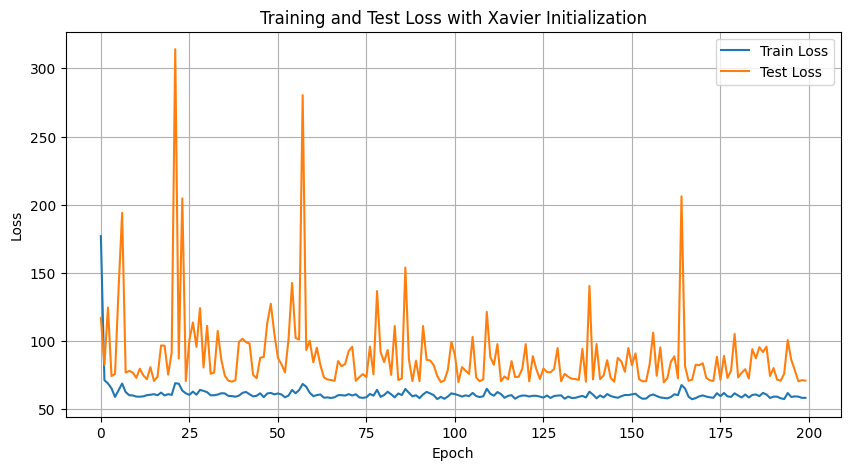

--------------------------------------------------
Initializing with He...
에포크 0  훈련 손실 573.8438  테스트 손실 542.9485
에포크 20  훈련 손실 60.2783  테스트 손실 91.7278
에포크 40  훈련 손실 61.2598  테스트 손실 106.2087
에포크 60  훈련 손실 59.4884  테스트 손실 82.9194
에포크 80  훈련 손실 59.8762  테스트 손실 82.6129
에포크 100  훈련 손실 60.2534  테스트 손실 83.2776
에포크 120  훈련 손실 59.6642  테스트 손실 92.3757
에포크 140  훈련 손실 57.7794  테스트 손실 93.8105
에포크 160  훈련 손실 57.3776  테스트 손실 71.3116
에포크 180  훈련 손실 59.4993  테스트 손실 73.4138
최종 테스트 MSE: 70.8997
최종 테스트 MAE: 7.4116


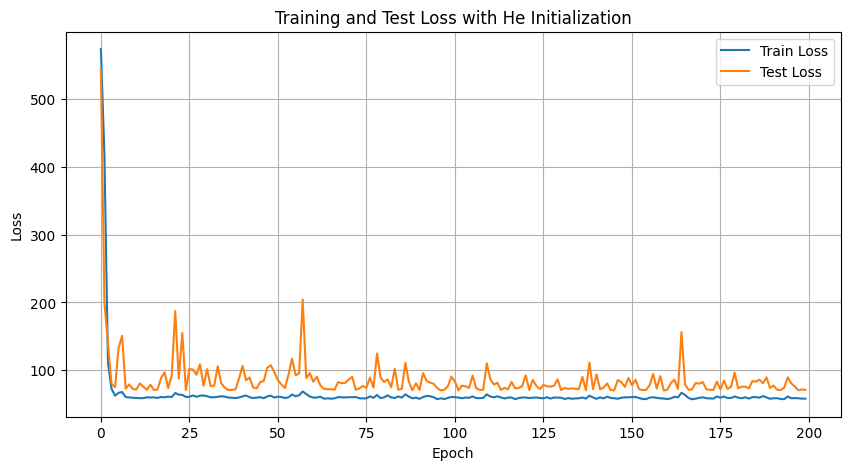

--------------------------------------------------
Initializing with Uniform...
에포크 0  훈련 손실 572.7937  테스트 손실 544.4139
에포크 20  훈련 손실 59.0209  테스트 손실 78.0498
에포크 40  훈련 손실 59.6212  테스트 손실 74.8184
에포크 60  훈련 손실 58.2041  테스트 손실 73.1028
에포크 80  훈련 손실 57.5883  테스트 손실 73.4457
에포크 100  훈련 손실 57.5230  테스트 손실 74.8167
에포크 120  훈련 손실 58.3473  테스트 손실 77.1243
에포크 140  훈련 손실 57.7433  테스트 손실 76.5265
에포크 160  훈련 손실 56.5517  테스트 손실 70.6988
에포크 180  훈련 손실 58.2066  테스트 손실 70.8180
최종 테스트 MSE: 70.3314
최종 테스트 MAE: 7.3230


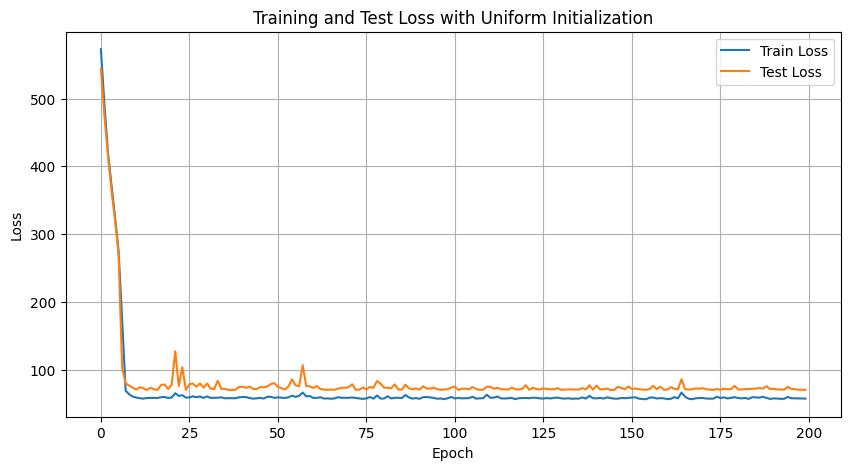

--------------------------------------------------
Initializing with Normal...
에포크 0  훈련 손실 572.4915  테스트 손실 543.2833
에포크 20  훈련 손실 59.5886  테스트 손실 83.6643
에포크 40  훈련 손실 60.4917  테스트 손실 85.4435
에포크 60  훈련 손실 58.6435  테스트 손실 77.1213
에포크 80  훈련 손실 58.5043  테스트 손실 76.3432
에포크 100  훈련 손실 58.4155  테스트 손실 77.7674
에포크 120  훈련 손실 58.6892  테스트 손실 81.6853
에포크 140  훈련 손실 57.6486  테스트 손실 80.8082
에포크 160  훈련 손실 56.7061  테스트 손실 70.7482
에포크 180  훈련 손실 58.2967  테스트 손실 71.1227
최종 테스트 MSE: 70.3245
최종 테스트 MAE: 7.3229


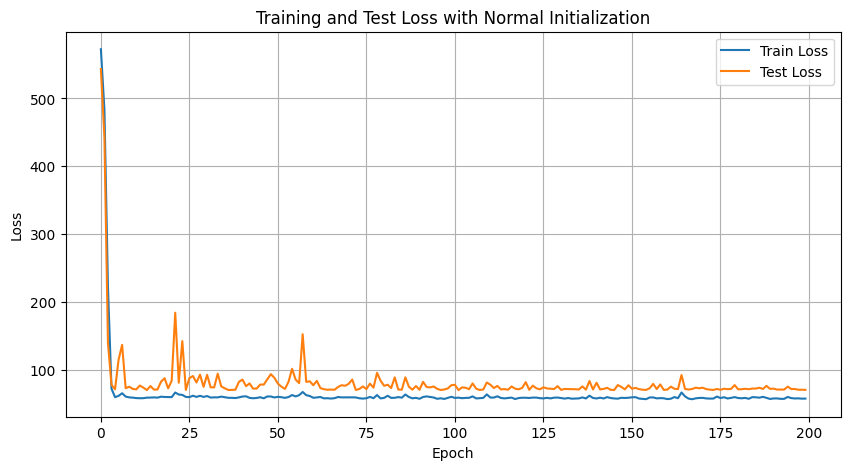

--------------------------------------------------


In [69]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def initialize_weights_xavier(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

def initialize_weights_he(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        nn.init.zeros_(layer.bias)

def initialize_weights_uniform(layer):
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
        nn.init.zeros_(layer.bias)

def initialize_weights_normal(layer):
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.zeros_(layer.bias)

# 가중치 초기화 방법 리스트
initializers = {
    "Xavier": initialize_weights_xavier,
    "He": initialize_weights_he,
    "Uniform": initialize_weights_uniform,
    "Normal": initialize_weights_normal
}

# 훈련 설정
batch_size = 8
torch.manual_seed(1)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [8, 4]
input_size = x_train.shape[1]

# 각 초기화 방법에 대해 반복
for init_name, init_function in initializers.items():
    print(f'Initializing with {init_name}...')

    # 모델 구성
    all_layers = []
    input_size = x_train.shape[1]  # 각 초기화에서 입력 크기를 초기화
    for hidden_unit in hidden_units:
        layer = nn.Linear(input_size, hidden_unit)
        all_layers.append(layer)
        all_layers.append(nn.ReLU())
        input_size = hidden_unit
    all_layers.append(nn.Linear(hidden_units[-1], 1))

    model = nn.Sequential(*all_layers)

    # 가중치 초기화
    model.apply(init_function)

    # 손실 함수 및 옵티마이저 설정
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # 손실을 기록할 리스트
    train_history = []
    test_history = []

    # 훈련 과정
    torch.manual_seed(1)
    num_epochs = 200
    log_epochs = 20
    for epoch in range(num_epochs):
        loss_hist_train = 0
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train += loss.item()

        # 손실 기록
        train_history.append(loss_hist_train / len(train_dl))

        # 테스트 손실 계산 및 기록
        with torch.no_grad():
            test_pred = model(x_test.float())[:, 0]
            test_loss = loss_fn(test_pred, y_test)
            test_history.append(test_loss.item())

        if epoch % log_epochs == 0:
            print(f'에포크 {epoch}  훈련 손실 {loss_hist_train / len(train_dl):.4f}  테스트 손실 {test_loss.item():.4f}')

    # 테스트 데이터에 대한 최종 평가
    with torch.no_grad():
        pred = model(x_test.float())[:, 0]
        final_loss = loss_fn(pred, y_test)
        print(f'최종 테스트 MSE: {final_loss.item():.4f}')
        print(f'최종 테스트 MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

    # 손실 그래프 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label='Train Loss')
    plt.plot(test_history, label='Test Loss')
    plt.title(f'Training and Test Loss with {init_name} Initialization')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('-' * 50)


# L1, L2 규제 적용

- 규제 강도가 0에 가까워질수록 모델은 더 많은 특징을 사용하므로 과대적합에 민감, 규제강도를 높이면 과소적합 문제에 노출.


# L1 (Lasso 규제, 절대값 규제)
- L1 정칙화를 적용하면 입력 데이터에 더 민감해짐. 모델의 가중치를 정확히 0으로 만드는 경우가 있어서 희소한 모델이 될 수 있음.
- 불필요한 특징을 처리하지 않아 모델 성능이 올라갈 수도 있지만, 예측에 사용되는 특징 수가 줄어들어 정보 손실이 생길 우려도 있음.
- 미분 불가로 인해 역전파 계산에 리소스 소모. 주로 선형 모델에 적용.


# L2 (Ridge 규제, 제곱합 규제)
- 벡터 또는 행렬 값이 크기를 계산하여 손실함수에 가중치의 제곱합을 추가해 과대적합을 방지하도록 규제함.
- 하나의 특징이 너무 중요한 요소가 되지 않도록 규제를 가하는 것에 의미를 둠. 가중치 값들이 비교적 균일하게 분포되며, 가중치가 0이 되지는 않고 0에 가까워짐.

In [71]:
from torch.utils.data import DataLoader, TensorDataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

from sklearn.preprocessing import StandardScaler

numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

# StandardScaler 객체 생성
scaler = StandardScaler()

# 훈련 데이터에 맞춰 스케일러 적합 및 변환
df_train_norm = df_train.copy()
df_train_norm[numeric_column_names] = scaler.fit_transform(df_train[numeric_column_names])

# 테스트 데이터 변환 (훈련 데이터의 스케일에 맞춰 변환)
df_test_norm = df_test.copy()
df_test_norm[numeric_column_names] = scaler.transform(df_test[numeric_column_names])

# 결과 확인
df_train_norm.tail()

# 훈련 모델의 복잡도를 단순화하기 위해 연식을 그룹으로 묶음. 더 최신 차일수록 높은 점수 부여(서수형 이산 변수)
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

from torch.nn.functional import one_hot

## 명목형으로 된변수들을 원핫인코딩
total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()


y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

## 로더에 싣고
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

## 모델을 만들어서
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

# 규제를 위한 하이퍼파라미터
l1_lambda = 0.5
l2_lambda = 0.5

## 일하는 방식 정의
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


## 실제 학습
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)

        # l1규제 추가
        l1_reg = sum(torch.abs(param).sum() for param in model.parameters())
        loss += l1_reg*l1_lambda

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs==0:
        print(f'에포크 {epoch}  손실 {loss_hist_train/len(train_dl):.4f}')

# 에포크 0  손실 536.0926
# 에포크 20  손실 8.4366

# 에포크 0  손실 550.9703
# 에포크 20  손실 17.7068

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
에포크 0  손실 550.9703
에포크 20  손실 17.7068
에포크 40  손실 16.7185
에포크 60  손실 16.0122
에포크 80  손실 15.5707
에포크 100  손실 15.2962
에포크 120  손실 15.0644
에포크 140  손실 15.4241
에포크 160  손실 16.2314
에포크 180  손실 15.2321


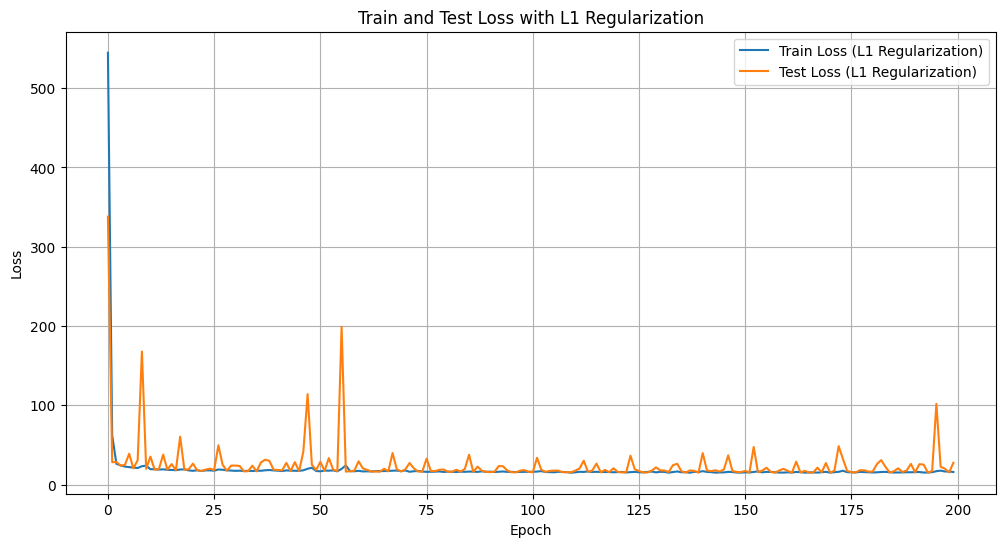

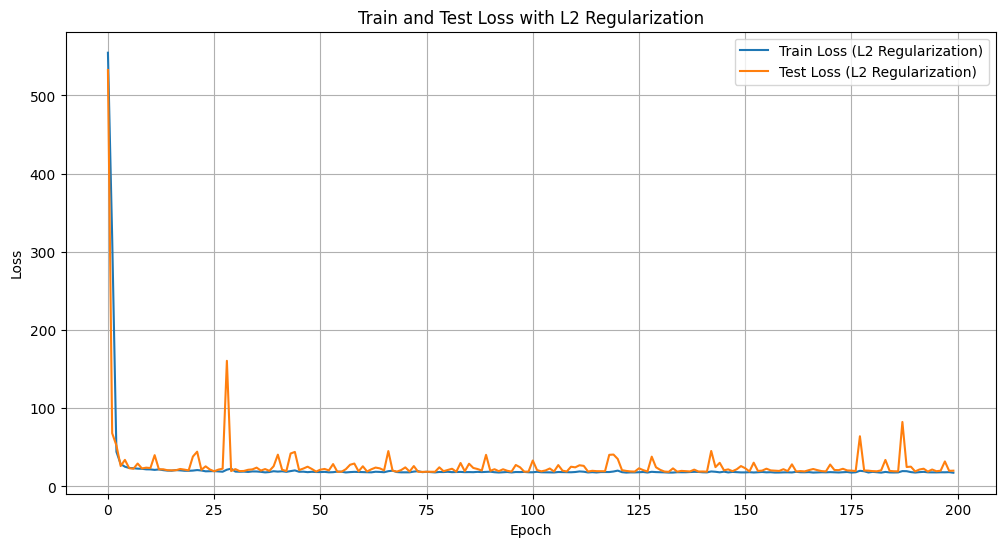

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 데이터 로딩
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# 모델 정의
hidden_units = [8, 4]

def create_model(input_size):
    all_layers = []
    for hidden_unit in hidden_units:
        layer = nn.Linear(input_size, hidden_unit)
        all_layers.append(layer)
        all_layers.append(nn.ReLU())
        input_size = hidden_unit

    all_layers.append(nn.Linear(hidden_units[-1], 1))
    return nn.Sequential(*all_layers)

# 규제를 위한 하이퍼파라미터
l1_lambda = 0.5  # L1 규제 강도
l2_lambda = 0.5  # L2 규제 강도

# 손실을 기록할 리스트
train_losses_l1 = []
test_losses_l1 = []
train_losses_l2 = []
test_losses_l2 = []

# L1 규제 적용
input_size = x_train.shape[1]  # input_size 설정
model = create_model(input_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(200):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)

        # L1 규제 추가
        l1_reg = sum(torch.abs(param).sum() for param in model.parameters())
        loss += l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    train_losses_l1.append(loss_hist_train / len(train_dl))

    # 테스트 손실 계산
    with torch.no_grad():
        pred = model(x_test.float())[:, 0]
        test_loss = loss_fn(pred, y_test)
        test_losses_l1.append(test_loss.item() + l1_lambda * sum(torch.abs(param).sum() for param in model.parameters()))

# L1 손실 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_losses_l1, label='Train Loss (L1 Regularization)')
plt.plot(test_losses_l1, label='Test Loss (L1 Regularization)')
plt.title('Train and Test Loss with L1 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# L2 규제 적용
model = create_model(input_size)  # input_size 설정
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(200):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)

        # L2 규제 추가
        l2_reg = sum((param ** 2).sum() for param in model.parameters())
        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    train_losses_l2.append(loss_hist_train / len(train_dl))

    # 테스트 손실 계산
    with torch.no_grad():
        pred = model(x_test.float())[:, 0]
        test_loss = loss_fn(pred, y_test)
        test_losses_l2.append(test_loss.item() + l2_lambda * sum((param ** 2).sum() for param in model.parameters()))

# L2 손실 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_losses_l2, label='Train Loss (L2 Regularization)')
plt.plot(test_losses_l2, label='Test Loss (L2 Regularization)')
plt.title('Train and Test Loss with L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 가중치 감쇠(weight_decay)
-  머신러닝과 딥러닝 모델에서 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나
- L2 정칙화를 옵티마이저에 제공하여 구현. 옵티마이저에 제시하면 손실함수에 규제를 부여하게 됨.
- 모델을 훈련할 때, 가중치 감쇠를 추가로 적용하면 가중치가 클수록 더 큰 페널티를 부여함. 이 페널티로 인해 모델은 가중치를 작게 만들려고 노력함.


In [73]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 데이터셋 준비
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [8, 4]
input_size = x_train.shape[1]

# 모델 구성
all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

# 손실 함수 및 옵티마이저 설정
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.5)  # 가중치 감쇠 적용
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# 훈련 과정
torch.manual_seed(1)
num_epochs = 500
log_epochs = 50
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'에포크 {epoch}  손실 {loss_hist_train / len(train_dl):.4f}')

# 테스트 데이터에 대한 평가
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'테스트 MSE: {loss.item():.4f}')
    print(f'테스트 MAE: {nn.L1Loss()(pred, y_test).item():.4f}')
'''
테스트 MSE: 9.3983
테스트 MAE: 1.9585
'''

'''
테스트 MSE: 8.7127
테스트 MAE: 1.9609
'''

에포크 0  손실 538.3551
에포크 50  손실 7.9416
에포크 100  손실 7.2269
에포크 150  손실 7.4001
에포크 200  손실 6.9636
에포크 250  손실 6.8263
에포크 300  손실 7.4589
에포크 350  손실 7.3378
에포크 400  손실 7.2355
에포크 450  손실 7.7618
테스트 MSE: 8.7127
테스트 MAE: 1.9609


'\n테스트 MSE: 8.7127\n테스트 MAE: 1.9609\n'

In [ ]:
#최종 테스트 MSE: 8.8187
#최종 테스트 MAE: 1.9245